In [383]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from sklearn.metrics import mean_absolute_error as mae
from sklearn.utils import shuffle

## I am downloading the large csv file and subsetting it to 15000 rows; the first 100 performance records to see if it will train

In [384]:
big_csv = pd.read_csv('LSTM_Model/out.csv', nrows = 500000)

In [385]:
del big_csv['Unnamed: 0']

In [386]:
big_csv['State'] = big_csv['State'].str.replace('"', '')
big_csv['date'] = big_csv.groupby('Performance Record').cumcount() + 1

In [387]:
import random

groups = [big_csv for _, big_csv in big_csv.groupby('Performance Record')]
random.shuffle(groups)

big_csv = pd.concat(groups).reset_index(drop=True)

In [401]:
big_csv

,Performance Record,ADNI,AP,ARH,MDNI,MaxSur,MinSur,AvgSur,date,Maturity Group,State,Year,Cluster,Yield
0,234,0.58,0.00,87.63,8.0,56.3,47.1,51.170,1,4,VA,2007,6.0,13.9
1,234,263.29,0.01,78.33,917.0,78.6,55.6,63.490,2,4,VA,2007,6.0,13.9
2,234,323.63,0.00,49.46,933.0,80.1,53.4,65.650,3,4,VA,2007,6.0,13.9
3,234,20.96,0.00,73.67,232.0,65.8,48.9,57.780,4,4,VA,2007,6.0,13.9
4,234,145.00,0.00,53.88,549.0,49.0,35.6,41.540,5,4,VA,2007,6.0,13.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,92,53.75,0.00,76.25,367.0,49.6,38.0,44.720,210,-1,ONT,2004,2.0,27.3
499996,92,244.17,0.00,78.46,924.0,49.2,28.9,37.310,211,-1,ONT,2004,2.0,27.3
499997,92,124.25,0.00,69.13,445.0,51.1,36.0,41.140,212,-1,ONT,2004,2.0,27.3
499998,92,0.00,0.01,82.13,0.0,60.3,42.0,45.745,213,-1,ONT,2004,2.0,27.3


## LSTM

In [429]:
# prepare data for lstm
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import datetime
import pandas as pd


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [430]:
#dataset = read_csv('LSTM_Model/avg_performance_record.csv', header=0, index_col=0)
dataset = big_csv
values = dataset.values

# Encoding the Sate Column
encoder = LabelEncoder()
values[:,10] = encoder.fit_transform(values[:,10])

values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict (keeping Yield in this case)
reframed.drop(reframed.columns[[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.100171   0.001254   0.000000   0.862050   0.007797   0.359375   
2   0.100171   0.569276   0.027778   0.758336   0.893762   0.591667   
3   0.100171   0.699741   0.000000   0.436378   0.909357   0.607292   
4   0.100171   0.045319   0.000000   0.706368   0.226121   0.458333   
5   0.100171   0.313514   0.000000   0.485670   0.535088   0.283333   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1   0.557531   0.445623   0.000000    0.555556         1.0    0.333328   
2   0.646443   0.584612   0.004695    0.555556         1.0    0.333328   
3   0.623431   0.608980   0.009390    0.555556         1.0    0.333328   
4   0.576360   0.520194   0.014085    0.555556         1.0    0.333328   
5   0.437238   0.336981   0.018779    0.555556         1.0    0.333328   

   var13(t-1)  var14(t-1)  var14(t)  
1    0.315789    0.091002  0.091002  
2    0.315789    0.091002  0.091002  
3    0.315789 

In [431]:
values = reframed.values
n_train_hours = int(len(dataset)*0.80)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(400000, 1, 14) (400000,) (99999, 1, 14) (99999,)


Epoch 1/35
1334/1334 - 5s - loss: 0.0404 - val_loss: 0.0058
Epoch 2/35
1334/1334 - 4s - loss: 0.0087 - val_loss: 0.0110
Epoch 3/35
1334/1334 - 4s - loss: 0.0085 - val_loss: 0.0048
Epoch 4/35
1334/1334 - 4s - loss: 0.0070 - val_loss: 0.0082
Epoch 5/35
1334/1334 - 4s - loss: 0.0070 - val_loss: 0.0096
Epoch 6/35
1334/1334 - 4s - loss: 0.0057 - val_loss: 0.0102
Epoch 7/35
1334/1334 - 4s - loss: 0.0053 - val_loss: 0.0033
Epoch 8/35
1334/1334 - 4s - loss: 0.0057 - val_loss: 0.0055
Epoch 9/35
1334/1334 - 4s - loss: 0.0055 - val_loss: 0.0032
Epoch 10/35
1334/1334 - 4s - loss: 0.0058 - val_loss: 0.0052
Epoch 11/35
1334/1334 - 4s - loss: 0.0054 - val_loss: 0.0040
Epoch 12/35
1334/1334 - 4s - loss: 0.0052 - val_loss: 0.0054
Epoch 13/35
1334/1334 - 4s - loss: 0.0052 - val_loss: 0.0055
Epoch 14/35
1334/1334 - 4s - loss: 0.0050 - val_loss: 0.0097
Epoch 15/35
1334/1334 - 4s - loss: 0.0049 - val_loss: 0.0024
Epoch 16/35
1334/1334 - 4s - loss: 0.0052 - val_loss: 0.0032
Epoch 17/35
1334/1334 - 4s - loss

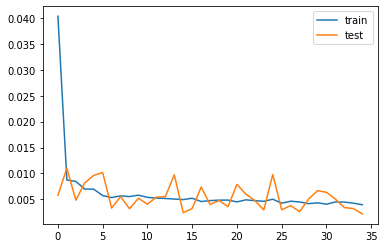

In [432]:
# design network
model = Sequential()
model.add(LSTM(60, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=35, batch_size=300, validation_data=(test_X, test_y), verbose=2, shuffle=False)
#plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [433]:
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [434]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
#invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
MAE = mae(inv_y, inv_yhat)
r2 = rsquared(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse, 'r-squared: %.6f' % r2, 'MAE: %.5f' % MAE)

Test RMSE: 35.676 r-squared: 0.990756 MAE: 5.06654
